#Cargar datos desde Kaggle

In [ ]:
# Instalar kaggle
!pip install kaggle

# Descargar el dataset
!kaggle datasets download mudasirazhar/cyanotoxins-identification-dataset -p /content/

# Descomprimir el archivo
!unzip /content/cyanotoxins-identification-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/mudasirazhar/cyanotoxins-identification-dataset
License(s): unknown
 88% 86.0M/97.2M [00:00<00:00, 90.6MB/s]
100% 97.2M/97.2M [00:00<00:00, 104MB/s] 
Archive:  /content/cyanotoxins-identification-dataset.zip
  inflating: Dataset/Test/Anabaena/03bef.png  
  inflating: Dataset/Test/Anabaena/04b28.png  
  inflating: Dataset/Test/Anabaena/0f002.png  
  inflating: Dataset/Test/Anabaena/15fe5.png  
  inflating: Dataset/Test/Anabaena/2.png  
  inflating: Dataset/Test/Anabaena/23ae7.png  
  inflating: Dataset/Test/Anabaena/24770.png  
  inflating: Dataset/Test/Anabaena/286e4.png  
  inflating: Dataset/Test/Anabaena/287c6.png  
  inflating: Dataset/Test/Anabaena/2ab5b.png  
  inflating: Dataset/Test/Anabaena/2ed3f.png  
  inflating: Dataset/Test/Anabaena/36195.png  
  inflating: Dataset/Test/Anabaena/38b2f.png  
  inflating: Dataset/Test/Anabaena/396d5.png  
  inflating: Dataset/Test/Anabaena/47936.png  
  inflating: Dataset/Test/Anabaena/4fb1f.png  

#Limpieza de datos

Esta parte tiene como objetivo analizar y evaluar la calidad de las imágenes dentro de la base de datos. La función principal es **`check_image_quality`**, que realiza diversas comprobaciones en cada imagen, tales como:

1. **Dimensiones mínimas:** Verifica si las imágenes cumplen con un tamaño adecuado para el análisis.
2. **Homogeneidad del fondo:** Detecta si el fondo es demasiado uniforme, lo que podría indicar imágenes de baja calidad.
3. **Nivel de enfoque:** Evalúa si la imagen está desenfocada mediante la variabilidad del Laplaciano.
4. **Contraste:** Calcula la entropía del histograma para detectar contrastes insuficientes.
5. **Saturación de color:** Mide la saturación promedio en el espacio de color HSV.
6. **Formato y modo de color:** Comprueba si el formato y los canales de color son compatibles con el modelo.
7. **Compresión:** Determina si la imagen está excesivamente comprimida al analizar la relación entre el tamaño del archivo y los píxeles.
8. **Rango dinámico:** Verifica la diferencia entre los valores máximo y mínimo de brillo para evaluar el rango tonal.
9. **Brillo promedio:** Evalúa si el nivel de brillo está en un rango óptimo.

Por otro lado, la función **`analyze_dataset`** aplica este análisis al conjunto de imágenes organizadas en carpetas por clase. Genera un reporte detallado con estadísticas por clase y globales, incluyendo el porcentaje de imágenes problemáticas, los tipos de problemas más frecuentes, y la distribución de formatos y modos de color. Además, puede opcionalmente mover las imágenes con problemas a una carpeta específica para facilitar su manejo.

Este procedimiento asegura que solo las imágenes de buena calidad sean utilizadas en el entrenamiento, optimizando la eficacia y precisión del modelo de clasificación.

In [ ]:
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [ ]:
def check_image_quality(image_path):
    """
    Realiza múltiples comprobaciones de calidad en una imagen.

    Args:
        image_path: Ruta a la imagen

    Returns:
        dict: Diccionario con los resultados de las comprobaciones
    """
    try:
        # Leer la imagen con OpenCV y PIL
        img_cv = cv2.imread(str(image_path))
        img_pil = Image.open(str(image_path))

        if img_cv is None:
            return {'valid': False, 'error': 'No se pudo leer la imagen'}

        results = {'valid': True, 'warnings': []}

        # 1. Comprobar dimensiones mínimas
        height, width = img_cv.shape[:2]
        if width < 150 or height < 150:
            results['warnings'].append('Dimensiones insuficientes')

        # 2. Verificar si es fondo sólido (umbral más estricto)
        gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
        std_dev = np.std(gray)
        if std_dev < 2:
            results['warnings'].append('Fondo demasiado uniforme')

        # 3. Detectar desenfoque (umbral más alto)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        if laplacian_var < 5:  # Aumentado de 10 a 50
            results['warnings'].append('Imagen desenfocada')

        # 4. Verificar contraste (umbral más alto)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist_norm = hist.ravel() / hist.sum()
        entropy = -np.sum(hist_norm * np.log2(hist_norm + 1e-7))
        if entropy < 1:
            results['warnings'].append('Contraste insuficiente')

        # 5. Comprobar saturación (umbral más alto)
        hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)
        saturation = hsv[:, :, 1].mean()
        if saturation < 5:
            results['warnings'].append('Saturación de color insuficiente')

        # 6. Verificar formato y modo de color
        results['format'] = img_pil.format
        results['mode'] = img_pil.mode
        if img_pil.mode not in ['RGB', 'RGBA']:
            results['warnings'].append(f'Modo de color no soportado: {img_pil.mode}')

        # 7. Comprobar compresión (umbral más estricto)
        file_size = Path(image_path).stat().st_size
        pixels = width * height
        bytes_per_pixel = file_size / pixels
        if bytes_per_pixel < .2:
            results['warnings'].append('Compresión excesiva')

        # 8. comprobación: Verificar rango dinámico
        min_val = np.min(gray)
        max_val = np.max(gray)
        dynamic_range = max_val - min_val
        if dynamic_range < 100:  # Nuevo umbral
            results['warnings'].append('Rango dinámico insuficiente')

        # 9. comprobación: Distribución de brillo
        mean_brightness = np.mean(gray)
        if mean_brightness < 40 or mean_brightness > 215:
            results['warnings'].append('Brillo promedio fuera de rango óptimo')

        return results

    except Exception as e:
        return {'valid': False, 'error': str(e)}

def analyze_dataset(root_folder, action='report'):
    """
    Analiza un dataset de imágenes realizando múltiples comprobaciones.

    Args:
        root_folder: Carpeta raíz que contiene las subcarpetas de clases
        action: 'report' solo reporta, 'move' mueve las imágenes con problemas
    """
    problem_folder = Path(root_folder) / 'problematic_images' if action == 'move' else None
    if problem_folder:
        problem_folder.mkdir(exist_ok=True)

    stats = {
        'total': 0,
        'problematic': 0,
        'warnings': {},
        'formats': {},
        'modes': {},
        'class_stats': {}  # Nuevo diccionario para estadísticas por clase
    }

    for class_folder in Path(root_folder).iterdir():
        if not class_folder.is_dir() or class_folder.name == 'problematic_images':
            continue

        print(f"\nAnalizando clase: {class_folder.name}")

        # Inicializar estadísticas para esta clase
        class_stats = {
            'total': 0,
            'problematic': 0,
            'warnings': {}
        }

        for img_path in class_folder.glob('*'):
            if img_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                print(f"Path de imagen no valido: {img_path}")
                continue

            stats['total'] += 1
            class_stats['total'] += 1

            results = check_image_quality(img_path)

            if not results['valid']:
                print(f"Error en {img_path.name}: {results.get('error', 'Error desconocido')}")
                continue

            # Actualizar estadísticas globales
            stats['formats'][results['format']] = stats['formats'].get(results['format'], 0) + 1
            stats['modes'][results['mode']] = stats['modes'].get(results['mode'], 0) + 1

            if results['warnings']:
                stats['problematic'] += 1
                class_stats['problematic'] += 1

                # Actualizar warnings globales y por clase
                for warning in results['warnings']:
                    stats['warnings'][warning] = stats['warnings'].get(warning, 0) + 1
                    class_stats['warnings'][warning] = class_stats['warnings'].get(warning, 0) + 1

                print(f"\nProblemas detectados en {img_path.name}:")
                for warning in results['warnings']:
                    print(f"- {warning}")

                if action == 'move':
                    class_problem_folder = problem_folder / class_folder.name
                    class_problem_folder.mkdir(exist_ok=True)
                    new_path = class_problem_folder / img_path.name
                    img_path.rename(new_path)

        # Guardar estadísticas de la clase
        stats['class_stats'][class_folder.name] = class_stats

    # Mostrar resumen
    print("\n=== RESUMEN DEL ANÁLISIS ===")
    print(f"Total de imágenes: {stats['total']}")
    print(f"Imágenes con problemas: {stats['problematic']} ({(stats['problematic']/stats['total']*100):.2f}%)")

    print("\nEstadísticas por clase:")
    for class_name, class_stats in stats['class_stats'].items():
        problematic_percent = (class_stats['problematic'] / class_stats['total'] * 100) if class_stats['total'] > 0 else 0
        print(f"\n{class_name}:")
        print(f"- Total de imágenes: {class_stats['total']}")
        print(f"- Imágenes con problemas: {class_stats['problematic']} ({problematic_percent:.2f}%)")
        print("- Desglose de problemas:")
        for warning, count in class_stats['warnings'].items():
            warning_percent = (count / class_stats['total'] * 100)
            print(f"  * {warning}: {count} imágenes ({warning_percent:.2f}%)")

    print("\nTipos de problemas encontrados (global):")
    for warning, count in stats['warnings'].items():
        print(f"- {warning}: {count} imágenes ({(count/stats['total']*100):.2f}%)")

    print("\nFormatos de imagen:")
    for format, count in stats['formats'].items():
        print(f"- {format}: {count} imágenes")

    print("\nModos de color:")
    for mode, count in stats['modes'].items():
        print(f"- {mode}: {count} imágenes")

    return stats

In [ ]:
dataset_path = "/content/Dataset/Train"
action = 'move'

stats = analyze_dataset(dataset_path, action)


Analizando clase: Planktothrix

Problemas detectados en 5ab65.png:
- Saturación de color insuficiente

Problemas detectados en Mcc_img1_1.png_f5e9c.png:
- Rango dinámico insuficiente

Problemas detectados en Mcc_img1_4.png_a0a5d.png:
- Rango dinámico insuficiente

Problemas detectados en Kpabg_img1_61f8b.png_8747e.png:
- Rango dinámico insuficiente
- Brillo promedio fuera de rango óptimo

Problemas detectados en Mcc_img1_2.png_59d6e.png:
- Rango dinámico insuficiente

Problemas detectados en Mcc_img1_3.png_fdf04.png:
- Rango dinámico insuficiente

Analizando clase: Rivularia

Problemas detectados en Screenshot 2024-08-12 204501.png:
- Brillo promedio fuera de rango óptimo

Analizando clase: Microcystis

Problemas detectados en Lege_img3_2_0b975.png:
- Contraste insuficiente
- Compresión excesiva

Problemas detectados en Kpabg_img7_3_760d3.png:
- Contraste insuficiente
- Compresión excesiva

Problemas detectados en Lege_img3_4_45894.png:
- Contraste insuficiente

Problemas detectados e

# Balanced Image Generator

**Características Principales**

**Configuración del Generador**
- **Objetivo**: Generar batches balanceados de imágenes para entrenamiento
- **Tamaño de imagen objetivo**: 224x224 píxeles
- **Split de validación**: 20%
- **Semilla aleatoria**: 42

**Estrategias de Balanceo**
- Ajuste automático del batch size para divisibilidad entre clases
- Selección de igual número de imágenes por clase
- Oversampling para clases con menos imágenes
- Selección aleatoria sin reemplazo cuando hay suficientes imágenes

**Métodos Clave:**

**Inicialización**
- Mapeo de clases a índices
- Carga de rutas de imágenes
- División de datos en entrenamiento/validación
- Cálculo de tamaños de clase

**Generación de Batches**
- Selección balanceada de imágenes
- Preprocesamiento:
  - Conversión a RGB
  - Redimensionamiento
  - Normalización [0, 1]
- Codificación one-hot de etiquetas



In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from pathlib import Path
from typing import Dict, List, Set, Tuple

class BalancedImageGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        root_folder: str,
        batch_size: int,
        steps_per_epoch: int = 200,
        target_size: Tuple[int, int] = (224, 224),
        validation: bool = False,
        validation_split: float = 0.2,
        seed: int = 42
    ):
        self.root_folder = Path(root_folder)
        self.target_size = target_size
        self.validation = validation
        self.validation_split = validation_split
        self.steps_per_epoch = steps_per_epoch
        np.random.seed(seed)

        # Mapeo de clases a índices
        self.class_names = sorted([d.name for d in self.root_folder.iterdir()
                                 if d.is_dir() and d.name != 'problematic_images' and d.name !='.ipynb_checkpoints'])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}
        self.n_classes = len(self.class_names)

        # Asegurar que batch_size es divisible por el número de clases
        if batch_size % self.n_classes != 0:
            batch_size = (batch_size // self.n_classes) * self.n_classes
            print(f"Ajustando batch_size a {batch_size} para garantizar balance entre clases")
        self.batch_size = batch_size
        self.samples_per_class_in_batch = self.batch_size // self.n_classes

        # Cargar paths de imágenes por clase
        self.class_images: Dict[str, List[Path]] = {}
        total_images = 0
        split_images = 0

        for class_name in self.class_names:
            valid_extensions = {'.jpg', '.jpeg', '.png'}
            images = [p for p in (self.root_folder / class_name).glob('*')
                     if p.suffix.lower() in valid_extensions]

            # Dividir en train/val
            np.random.shuffle(images)
            split_idx = int(len(images) * (1 - validation_split))

            if validation:
                self.class_images[class_name] = images[split_idx:]
                split_images += len(images[split_idx:])
            else:
                self.class_images[class_name] = images[:split_idx]
                split_images += len(images[:split_idx])
            total_images += len(images)

        # Registrar el tamaño del dataset más grande
        self.max_class_size = max(len(imgs) for imgs in self.class_images.values())
        self.class_sizes = {cls: len(imgs) for cls, imgs in self.class_images.items()}

        # Imprimir información detallada
        split_type = "VALIDACIÓN" if validation else "ENTRENAMIENTO"
        print(f"\nInicializando generador de {split_type}")
        print(f"Directorio: {root_folder}")
        print(f"Total de imágenes encontradas: {total_images}")
        print(f"Imágenes usadas para este split ({split_type}): {split_images}")
        print(f"Batch size: {batch_size} ({self.samples_per_class_in_batch} imágenes por clase)")
        print(f"Pasos por época: {steps_per_epoch}")
        print("\nDistribución por clase:")
        for cls, size in self.class_sizes.items():
            print(f"{cls}: {size} imágenes")

        self.on_epoch_end()

    def on_epoch_end(self):
        """
        Reinicia el estado para la siguiente época.
        """
        self.available_images = {
            class_name: set(range(len(images)))
            for class_name, images in self.class_images.items()
        }
        self.used_in_epoch = {class_name: set() for class_name in self.class_names}

    def _get_indices_for_class(self, class_name: str, n_samples: int) -> List[int]:
        """
        Obtiene índices de imágenes para una clase específica.
        Hace oversampling si no hay suficientes imágenes.
        """
        total_images = len(self.class_images[class_name])

        # Si necesitamos más imágenes que las disponibles, hacemos oversampling
        if n_samples > total_images:
            # Primero usamos todas las imágenes disponibles
            indices = list(range(total_images))
            # Luego hacemos oversampling aleatorio para las restantes
            additional_needed = n_samples - total_images
            indices.extend(np.random.choice(total_images, size=additional_needed, replace=True))
            np.random.shuffle(indices)
            return indices
        else:
            # Si tenemos suficientes imágenes, seleccionamos aleatoriamente sin reemplazo
            return list(np.random.choice(total_images, size=n_samples, replace=False))

    def __len__(self):
        """
        Determina el número de batches por época usando el parámetro steps_per_epoch.
        """
        return self.steps_per_epoch

    def __getitem__(self, idx):
        """
        Obtiene un batch balanceado de datos.
        """
        batch_indices = []

        # Obtener igual número de muestras de cada clase
        for class_name in self.class_names:
            indices = self._get_indices_for_class(class_name, self.samples_per_class_in_batch)
            batch_indices.extend([(class_name, idx) for idx in indices])

        # Mezclar el batch
        np.random.shuffle(batch_indices)

        # Preparar arrays
        X = np.empty((len(batch_indices), *self.target_size, 3), dtype=np.float32)
        y = np.empty(len(batch_indices), dtype=np.int32)

        # Cargar y preprocesar imágenes
        for i, (class_name, img_idx) in enumerate(batch_indices):
            img_path = self.class_images[class_name][img_idx]
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            X[i] = img.astype(np.float32) / 255.0
            y[i] = self.class_to_idx[class_name]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
train_gen = BalancedImageGenerator(
    root_folder='Dataset/Train',
    batch_size=13*4,
    steps_per_epoch=250,
    target_size=(224, 224),
    validation=False,           # Este usará la porción de entrenamiento
    validation_split=0.2        # 20% para validación
)

val_gen = BalancedImageGenerator(
    root_folder='Dataset/Train',
    batch_size=26,
    steps_per_epoch=50,         # Menos pasos para validación
    target_size=(224, 224),
    validation=True,            # Este usará la porción de validación
    validation_split=0.2        # Mismo split que en train
)


Inicializando generador de ENTRENAMIENTO
Directorio: Dataset/Train
Total de imágenes encontradas: 2192
Imágenes usadas para este split (ENTRENAMIENTO): 1749
Batch size: 52 (4 imágenes por clase)
Pasos por época: 250

Distribución por clase:
Anabaena: 137 imágenes
Aphanizomenon: 22 imágenes
Chroococcales: 104 imágenes
Cylindrospermopsis: 17 imágenes
Dolichospermum: 93 imágenes
Microcystis: 700 imágenes
Nostoc: 183 imágenes
Oscillatoria: 112 imágenes
Phormidium: 166 imágenes
Planktothrix: 78 imágenes
Raphidiopsis: 9 imágenes
Rivularia: 51 imágenes
Synechococcus: 77 imágenes

Inicializando generador de VALIDACIÓN
Directorio: Dataset/Train
Total de imágenes encontradas: 2192
Imágenes usadas para este split (VALIDACIÓN): 443
Batch size: 26 (2 imágenes por clase)
Pasos por época: 50

Distribución por clase:
Anabaena: 35 imágenes
Aphanizomenon: 6 imágenes
Chroococcales: 26 imágenes
Cylindrospermopsis: 5 imágenes
Dolichospermum: 24 imágenes
Microcystis: 175 imágenes
Nostoc: 46 imágenes
Oscill

# Arquitectura ResNet

**Descripción General**
- **Tipo de Modelo**: Arquitectura ResNet personalizada
- **Variante**: ResNet-18
- **Propósito**: Clasificación de imágenes

**Componentes Arquitecturales:**

**Bloques Principales**
1. **Bloque Inicial**
   - Convolución 7x7
   - Normalización por lotes
   - Activación ReLU
   - Max Pooling 2D

2. **Bloques Residuales**
   - Conexiones de identidad
   - Convoluciones 3x3
   - Normalización por lotes
   - Activaciones ReLU

3. **Clasificación Final**
   - Global Average Pooling
   - Capa densa softmax

**Características Técnicas:**
- Aumento de datos integrado
- Stride y padding dinámicos
- Escalado automático de filtros

**Estrategias de Diseño**

**Aumento de Datos:**
- Rotación aleatoria (±10%)
- Translación aleatoria (±10%)

**Optimización Estructural:**
- Bloques residuales para gradiente
- Normalización por lotes
- Activaciones no lineales

**Hiperparámetros Configurables:**
- Forma de entrada de imagen
- Número de clases
- Número de bloques por etapa


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Dropout

def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    """
    Bloque residual básico de ResNet
    """
    shortcut = x

    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Primera capa convolucional
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Segunda capa convolucional
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Suma de la conexión residual
    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    return x

def create_resnet(input_shape, num_classes, blocks=[2, 2, 2, 2]):
    """
    Crea un modelo ResNet
    blocks: lista con el número de bloques residuales en cada etapa
    """
    inputs = Input(shape=input_shape)

    #Aumento de datos
    x = tf.keras.layers.RandomRotation(0.1)(inputs)
    x = tf.keras.layers.RandomTranslation(0.1, 0.1)(x)

    # Bloque inicial
    x = Conv2D(64, 7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # Bloques residuales
    filters = 64
    for i, block_count in enumerate(blocks):
        for j in range(block_count):
            stride = 2 if j == 0 and i > 0 else 1
            x = residual_block(x, filters, stride=stride,
                             conv_shortcut=(j == 0))
        filters *= 2

    # Clasificación final
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Crear y compilar modelo
    model = Model(inputs, outputs)

    return model


def create_resnet18(input_shape, num_classes):
    """
    Crea una ResNet-18
    """
    return create_resnet(input_shape, num_classes, blocks=[2, 2, 2, 2])


## Entrenamiento de Modelo ResNet18

**Arquitectura del Modelo**
ResNet18 configurado para clasificación de imágenes con características:
- Entrada: Imágenes de 224x224 píxeles
- Canales: 3 canales de color RGB
- Salida: Clasificación multiclase según el número de clases del dataset

**Configuración de Compilación**
Preparación del modelo con parámetros optimizados:
- Optimizador: Adam
- Tasa de aprendizaje: 1e-5 (adaptativa)
- Función de pérdida: Categorical Crossentropy
- Métrica de evaluación: Precisión (Accuracy)

**Callbacks Avanzados**

*Reducción Dinámica de Learning Rate*
Callback personalizado que:
- Reduce automáticamente la tasa de aprendizaje cada 10 épocas
- Factor de reducción: 0.1
- Límite mínimo de tasa de aprendizaje: 1e-12
- Objetivo: Refinamiento progresivo de los pesos de la red neuronal

*Early Stopping*
Mecanismo inteligente de parada anticipada:
- Monitor: Precisión de validación
- Condición de parada: Sin mejora después de 7 épocas
- Modo: Maximización de la precisión
- Restauración de mejores pesos: Activada
- Beneficios:
  - Previene sobreajuste
  - Optimiza tiempo de entrenamiento
  - Garantiza mejor rendimiento del modelo

**Estrategia de Entrenamiento**
Proceso de entrenamiento diseñado para máxima eficiencia:
- Generadores de datos para entrenamiento y validación
- Duración máxima: 30 épocas
- Callbacks integrados:
  - Reducción adaptativa de learning rate
  - Parada temprana basada en rendimiento

In [ ]:
modelo = create_resnet18((224, 224, 3), train_gen.n_classes)

# Compilar el modelo con una tasa de aprendizaje baja para el reentrenamiento
modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
import tensorflow as tf

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs_to_wait, reduce_factor, min_lr):
        super(CustomCallback, self).__init__()
        self.epochs_to_wait = epochs_to_wait
        self.reduce_factor = reduce_factor
        self.min_lr = min_lr

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epochs_to_wait == 0 and epoch != 0:

            old_lr = self.model.optimizer._learning_rate
            new_lr = max(float(old_lr) * self.reduce_factor, self.min_lr)
            self.model.optimizer._learning_rate.assign(new_lr)
            print(f"\n\nReduciendo el learning rate de {float(old_lr)} a {new_lr}")









In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

callbacks = [
    early_stopping,
    CustomCallback(epochs_to_wait=10, reduce_factor=0.1, min_lr=1e-12)
]

modelo.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 89s 281ms/step - accuracy: 0.3774 - loss: 1.8733 - val_accuracy: 0.0762 - val_loss: 4.6087
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 286ms/step - accuracy: 0.7032 - loss: 0.9035 - val_accuracy: 0.1954 - val_loss: 3.3997
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 288ms/step - accuracy: 0.7947 - loss: 0.6408 - val_accuracy: 0.6077 - val_loss: 1.3212
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 288ms/step - accuracy: 0.8525 - loss: 0.4742 - val_accuracy: 0.6631 - val_loss: 1.1844
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 286ms/step - accuracy: 0.8853 - loss: 0.3684 - val_accuracy: 0.6185 - val_loss: 1.4002
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 73s 289ms/step - accuracy: 0.9174 - loss: 0.2713 - val_accuracy: 0.6954 - val_loss: 1.2779
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 288ms/step - accuracy: 0.9339 - loss: 0.2211 - val_accuracy: 0.6431 - val_loss: 1.4226
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 287ms/step - accuracy: 0.9420 - loss: 0.1739 - val

## Evaluación de Modelo de Clasificación

**Clase TestDataGenerator**
Clase personalizada diseñada para cargar y preparar datos de prueba para evaluación de modelos de clasificación de imágenes. Sus características principales incluyen:

- Carga de imágenes desde directorios específicos
- Mapeo de nombres de clases a índices
- Conversión de imágenes a tamaño objetivo (224x224)
- Normalización de píxeles (0-1)
- Generación de etiquetas categóricas

**Proceso de Carga de Datos**
El método `load_data()` realiza los siguientes pasos:
- Lee imágenes desde rutas de archivos
- Convierte imágenes de BGR a RGB
- Redimensiona imágenes al tamaño objetivo
- Normaliza valores de píxeles (división por 255)
- Genera etiquetas en formato one-hot encoding

**Función de Verificación de Resultados**
La función `verificar_resultados_test()` ejecuta un análisis completo del rendimiento del modelo:

- Genera predicciones sobre el conjunto de datos de prueba
- Calcula métricas de evaluación:
  - Precisión global
  - Informe de clasificación detallado
  - Matriz de confusión

**Visualización de Resultados**
Incluye una visualización de la matriz de confusión mediante:
- Gráfico de calor con seaborn
- Etiquetas de clases en ejes x e y
- Anotaciones con valores de predicciones

**Salidas Generadas**
Retorna un diccionario con:
- Informe de clasificación
- Matriz de confusión
- Precisión global
- Predicciones del modelo
- Etiquetas verdaderas originales

El enfoque permite una evaluación exhaustiva del rendimiento del modelo de clasificación, proporcionando información detallada sobre el desempeño en cada clase.

In [ ]:
class TestDataGenerator:
    def __init__(
        self,
        root_folder: str,
        class_names: Tuple[str,str],
        target_size: Tuple[int, int] = (224, 224),
    ):
        self.root_folder = Path(root_folder)
        self.target_size = target_size

        # Mapeo de clases a índices (mantener el mismo orden que en entrenamiento)
        self.class_names = class_names
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}
        self.n_classes = len(self.class_names)

        # Cargar paths de todas las imágenes
        self.images = []
        self.labels = []

        for class_name in self.class_names:
            valid_extensions = {'.jpg', '.jpeg', '.png'}
            class_images = [p for p in (self.root_folder / class_name).glob('*')
                          if p.suffix.lower() in valid_extensions]

            self.images.extend(class_images)
            self.labels.extend([self.class_to_idx[class_name]] * len(class_images))

        print(f"\nCargador de datos de test inicializado:")
        print(f"Directorio: {root_folder}")
        print(f"Total de imágenes: {len(self.images)}")
        print("\nDistribución por clase:")
        class_counts = {}
        for label, class_name in enumerate(self.class_names):
            count = sum(1 for l in self.labels if l == label)
            class_counts[class_name] = count
            print(f"{class_name}: {count} imágenes")

    def load_data(self):
        """
        Carga todas las imágenes de test y retorna X, y
        """
        X = np.empty((len(self.images), *self.target_size, 3), dtype=np.float32)

        for i, img_path in enumerate(self.images):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            X[i] = img.astype(np.float32) / 255.0

        y = tf.keras.utils.to_categorical(self.labels, num_classes=self.n_classes)

        return X, y

    def get_image_paths(self):
        """
        Retorna la lista de paths de las imágenes en el mismo orden que los datos
        """
        return self.images

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

def verificar_resultados_test(path_dataset, model, class_names):
    """
    Realiza predicciones en el conjunto de datos de prueba y genera métricas de evaluación.

    Args:
        path_dataset: path al dataset
        model: Modelo de TensorFlow/Keras entrenado
        class_names: Lista con los nombres de las clases

    Returns:
        dict: Diccionario con las métricas y visualizaciones
            - 'classification_report': Informe detallado de clasificación
            - 'confusion_matrix': Matriz de confusión
            - 'accuracy': Precisión global del modelo
            - 'predictions': Array con las predicciones
            - 'true_labels': Array con las etiquetas verdaderas
    """
    # Crear el generador de test
    test_gen = TestDataGenerator(
        root_folder=path_dataset,
        class_names=class_names,
        target_size=(224, 224)
    )

    # Cargar todos los datos de test
    X_test, y_test = test_gen.load_data()

    # Convertir y_test a codificación one-hot si no lo está ya
    if len(y_test.shape) == 1:
        n_classes = len(np.unique(y_test))
        y_test_orig = y_test  # Guardar las etiquetas originales
        y_test = tf.keras.utils.to_categorical(y_test, n_classes)
    else:
        y_test_orig = np.argmax(y_test, axis=1)  # Convertir one-hot a etiquetas numéricas

    # Realizar predicciones
    y_pred_probs = model.predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convertir probabilidades a etiquetas

    # Calcular métricas usando las etiquetas numéricas
    conf_matrix = confusion_matrix(y_test_orig, y_pred)

    # Generar reporte de clasificación
    clf_report = classification_report(
        y_test_orig,
        y_pred,
        labels=range(len(class_names)),
        target_names=class_names,
        zero_division=0,
        output_dict=True
    )

    # Calcular accuracy global
    accuracy = np.mean(y_pred == y_test_orig)

    # Imprimir resultados principales
    print(f"\nPrecisión Global: {accuracy:.4f}")
    print("\nInforme de Clasificación:")
    print(classification_report(y_test_orig, y_pred, target_names=class_names))
    print("\nMatriz de Confusión:")
    print(conf_matrix)

    # Visualizar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Matriz de Confusión')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

    # Retornar diccionario con todos los resultados
    return {
        'classification_report': clf_report,
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'predictions': y_pred,
        'true_labels': y_test_orig
    }


Cargador de datos de test inicializado:
Directorio: /content/Dataset/Test
Total de imágenes: 595

Distribución por clase:
Anabaena: 56 imágenes
Aphanizomenon: 4 imágenes
Chroococcales: 33 imágenes
Cylindrospermopsis: 3 imágenes
Dolichospermum: 33 imágenes
Microcystis: 235 imágenes
Nostoc: 73 imágenes
Oscillatoria: 32 imágenes
Phormidium: 61 imágenes
Planktothrix: 19 imágenes
Raphidiopsis: 4 imágenes
Rivularia: 17 imágenes
Synechococcus: 25 imágenes
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

Precisión Global: 0.8034

Informe de Clasificación:
                    precision    recall  f1-score   support

          Anabaena       0.76      0.57      0.65        56
     Aphanizomenon       0.25      0.25      0.25         4
     Chroococcales       0.73      0.67      0.70        33
Cylindrospermopsis       0.33      0.33      0.33         3
    Dolichospermum       0.67      0.91      0.77        33
       Microcystis       0.96      0.92      0.94       235
            Nostoc       0.83   

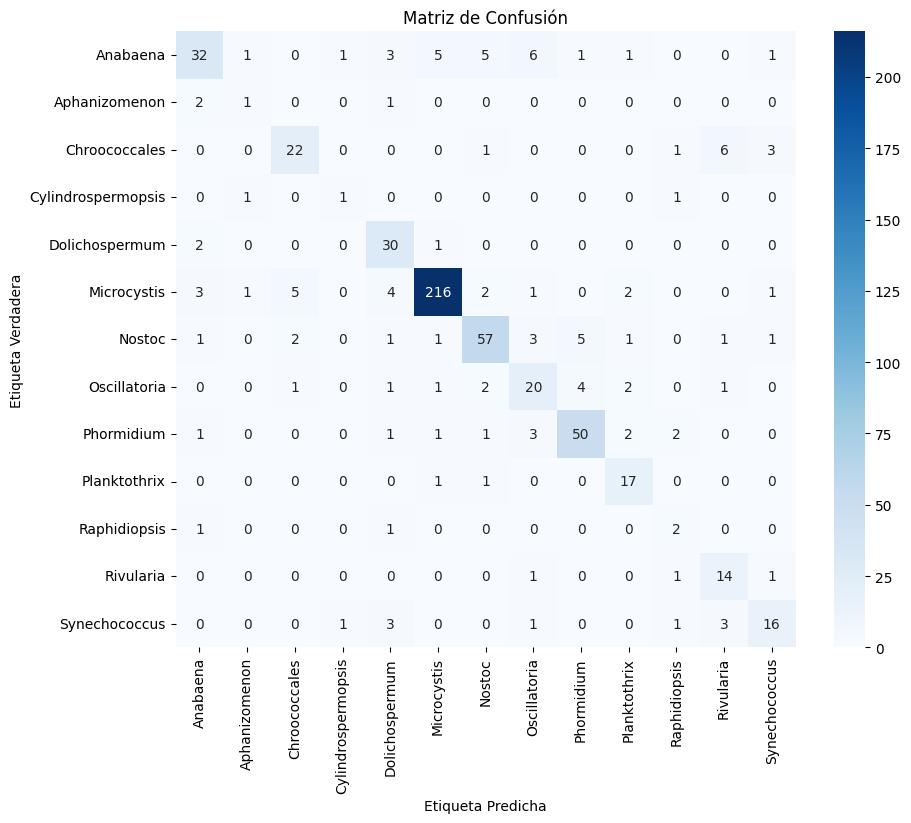

In [ ]:
_=verificar_resultados_test('/content/Dataset/Test', modelo, train_gen.class_names)